In [1]:
from unityagents import UnityEnvironment
import numpy as np
import time
import matplotlib.pyplot as plt
from agent import Agent
from collections import deque

import torch

In [2]:
#Single Agent reacher
env = UnityEnvironment(file_name='../../unity/Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Examine State and Action Space

<p>
In this environment, a double-jointed arm can move to target locations. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.
</p>
<p>
The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector must be a number between -1 and 1.
</p>

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## Random Walk

In [5]:
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
i = 0
while True:
    i+=1
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        print(i)
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

1001
Total score (averaged over agents) this episode: 0.0


# DDPG Implementation

In [6]:
state_dim = int(env_info.vector_observations.shape[1])
action_dim = int(brain.vector_action_space_size)
#Declare Agent class
agent = Agent(state_size=state_dim, action_size=action_dim)

In [7]:
def ddpg(episodes, pretrained=False, noise=True):
    """Training using DDPG"""
    if pretrained:
        agent.actor_local.load_state_dict(torch.load('../models/weights/checkpoint_actor.pth', map_location="cpu"))
        agent.critic_local.load_state_dict(torch.load('../models/weights/checkpoint_critic.pth', map_location="cpu"))
        agent.actor_target.load_state_dict(torch.load('../models/weights/checkpoint_actor.pth', map_location="cpu"))
        agent.critic_target.load_state_dict(torch.load('../models/weights/checkpoint_critic.pth', map_location="cpu"))

    reward_list = []
    reward_deque = deque(maxlen=10)
    
    for i in range(episodes):
        env_info = env.reset(train_mode=True)[brain_name] #reset the env.
        agent.reset()#reset OUNoise level
        state = env_info.vector_observations[0] # get the current state
        score = 0
        time_step = 0
        while True:
            action = agent.act(state, add_noise=noise)
            env_info = env.step(action[0])[brain_name] # send the action to the environment
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]#single agent reward
            done = env_info.local_done[0]
            
            agent.step(state, action, reward, next_state, done, time_step)
            
            state = next_state.squeeze()
            score += reward
            time_step += 1
            if done:
                #print recent statistics every 10 episodes
                if(i%10 == 0 and i > 0):
                    print('Reward: {} | Episode: {}/{}'.format(np.mean(reward_deque), i, episodes))
                break

        reward_list.append(score)
        reward_deque.append(score)
        
        #Save model every 100 episodes
        if(i%100 == 0 and i > 0):
            print(f"\nMEAN REWARD: {np.mean(reward_deque)}\n")
            torch.save(agent.actor_local.state_dict(), '../models/checkpoint/checkpoint_actor_'+str("%02d" % (i//100))+'.pth')
            torch.save(agent.critic_local.state_dict(), '../models/checkpoint/checkpoint_critic_'+str("%02d" % (i//100))+'.pth')
            torch.save(agent.actor_target.state_dict(), '../models/checkpoint/checkpoint_actor_t_'+str("%02d" % (i//100))+'.pth')
            torch.save(agent.critic_target.state_dict(), '../models/checkpoint/checkpoint_critic_t_'+str("%02d" % (i//100))+'.pth')
            
        if np.mean(reward_list[-100:]) >= 30:
            print('Task Solved')
            torch.save(agent.actor_local.state_dict(), '../models/weights/checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), '../models/weights/checkpoint_critic.pth')
            torch.save(agent.actor_target.state_dict(), '../models/weights/checkpoint_actor_t.pth')
            torch.save(agent.critic_target.state_dict(), '../models/weights/checkpoint_critic_t.pth')
            break
        

    torch.save(agent.actor_local.state_dict(), '../models/weights/checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), '../models/weights/checkpoint_critic.pth')
    torch.save(agent.actor_target.state_dict(), '../models/weights/checkpoint_actor_t.pth')
    torch.save(agent.critic_target.state_dict(), '../models/weights/checkpoint_critic_t.pth')

    print('Training saved')
    return reward_list

In [8]:
scores = ddpg(episodes=100) #Train

Reward: 0.0 | Episode: 10/100
Reward: 0.052999998815357684 | Episode: 20/100
Reward: 0.03899999912828207 | Episode: 30/100
Reward: 0.024999999441206455 | Episode: 40/100
Reward: 0.022999999485909937 | Episode: 50/100
Reward: 0.011999999731779098 | Episode: 60/100
Reward: 0.013999999687075614 | Episode: 70/100
Reward: 0.0 | Episode: 80/100
Reward: 0.0 | Episode: 90/100
Training saved


# Analysis

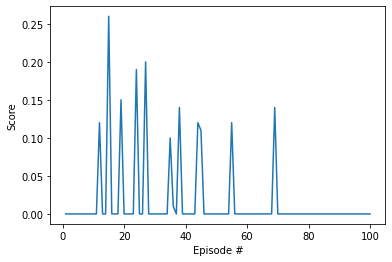

In [9]:
#Display Scores
fig = plt.figure()
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()